In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn. model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
pd.set_option('mode.chained_assignment', None)
from collections import Counter
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRFRegressor, XGBRegressor
import seaborn as sns
import zipfile
from math import ceil, floor


# test data 

In [2]:
## apply the linear regression to the USA test wells
test=pd.read_csv('val_data_no_label.csv')
test_canada=test[test['Field']=='Duvernay']
test_USA=test[test['Field']=='Eaglebine']  # note 'UWI' type-'object'
testcan=test_canada[['UWI']]
testusa=test_USA[['UWI']]

# Canada wells 

In [3]:
df_can=pd.read_csv('CANADA_Wells.csv')
df_can.head(2)

,Unnamed: 0,Well ID,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,...,diff_depth_abs,True Temperature (oC),TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource
0,0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,...,4.0,60.97,synthetic,NaN,NaN,NaN,NaN,NaN,60.97,synthetic
1,1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,...,4.4,63.98,synthetic,NaN,NaN,NaN,NaN,NaN,63.98,synthetic


In [4]:
lat_lon=pd.read_csv('Lat_Lon.csv')


In [5]:
df_can=df_can.merge(lat_lon, on='UWI')
#df_can.isnull().sum()

In [6]:
cols=['UWI','DST End Depth (MD) (m)', 'TrueTemp_datasource','Test Type', 'diff_depth_abs', 'DST Bottom Hole Temp. (degC)', 'Depth_SS(m)', 'lat',
'long','True Temperature (oC)']

In [7]:
can=df_can[cols]
can.shape

(499, 10)

In [8]:
can.isnull().sum()

UWI                               0
DST End Depth (MD) (m)            0
TrueTemp_datasource               0
Test Type                         0
diff_depth_abs                  127
DST Bottom Hole Temp. (degC)      0
Depth_SS(m)                       0
lat                               0
long                              0
True Temperature (oC)           127
dtype: int64

In [12]:
can['diff_depth_abs'].median()

4.85

In [11]:
can['diff_depth_abs'].fillna(4.85, inplace=True)

In [9]:
def dif_depth(depth):
    int_min, int_max=int(floor(depth/20)), int(ceil(depth/20))
    low_value=depth-int_min*20
    high_value=np.abs(depth-int_max*20)
    return round(min(low_value, high_value),1)   
    

In [10]:
def dif_depth_negative(depth):
    int_min, int_max=int(floor(depth/20)), int(ceil(depth/20))
    low_value=depth-int_min*20
    high_value=int_max*20-depth
    if  high_value<low_value:
        return round(-1*high_value,1) 
    else:
        return round(low_value,1)
    

In [13]:
# create the bins for the depth 
bins=[-1000, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500]
can_label=[1,2,3,4,5, 6,7,8]
can['binned']=pd.cut(can['Depth_SS(m)'], bins, labels=can_label)

In [14]:
# IQR outlier
Q1=can.groupby(["binned"])["DST Bottom Hole Temp. (degC)"].quantile(0.25)
Q3=can.groupby(["binned"])["DST Bottom Hole Temp. (degC)"].quantile(0.75)
IQR=Q3-Q1
LW=Q1-1.5*IQR
HW=Q3+1.5*IQR
LWV=LW.to_dict()
HWV=HW.to_dict()


In [15]:
can['LWV']=can['binned'].map(LWV)
can['HWV']=can['binned'].map(HWV)

In [16]:
can.iloc[:, 5:]

,DST Bottom Hole Temp. (degC),Depth_SS(m),lat,long,True Temperature (oC),binned,LWV,HWV
0,48.33,716.00,55.027981,-116.903553,60.97,3,29.71500,76.39500
1,34.26,1044.40,55.987511,-115.390554,63.98,4,17.41250,101.35250
2,29.00,171.90,54.167402,-113.002616,39.07,2,20.63000,56.51000
3,64.00,936.40,54.969037,-116.188158,69.47,3,29.71500,76.39500
4,68.00,1065.60,52.787328,-114.415621,75.23,4,17.41250,101.35250
...,...,...,...,...,...,...,...,...
494,120.00,2202.75,54.351621,-116.583782,NaN,6,50.69500,140.91500
495,72.50,1513.50,51.834511,-113.296734,NaN,5,50.27875,106.94875
496,83.89,2176.75,54.380089,-116.633753,NaN,6,50.69500,140.91500
497,68.80,1341.20,53.072353,-115.285653,81.48,4,17.41250,101.35250


In [17]:
can[['LWV', 'binned','HWV']]=can[['LWV', 'binned','HWV']].apply(pd.to_numeric)

<AxesSubplot:xlabel='binned', ylabel='DST Bottom Hole Temp. (degC)'>

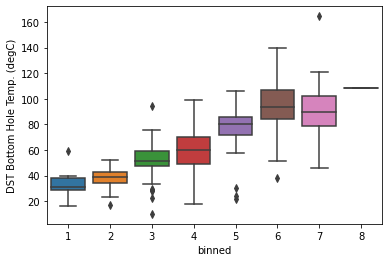

In [467]:
sns.boxplot(x='binned', y='DST Bottom Hole Temp. (degC)', data=can)

In [ ]:
# remove the 3 wells BHT is higher then True Temp

In [21]:
# find the outlier data
can.rename(columns={'DST Bottom Hole Temp. (degC)': 'BHT'}, inplace=True)
can1=can.dropna()
can_outliers=can1[(can.BHT>can.HWV)]
can_outliers.iloc[:, 5:]
outlier_UWI=list(can_outliers['UWI'].unique())
outlier_UWI

C:\Users\cryst\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


['100060807808W500', '100150106318W500']

In [299]:
#can['BHT1']=can.apply(lambda row: row['LWV'] if row['BHT']<row['LWV'] else (row['HWV'] if row['BHT']>row['HWV'] else row['BHT']), axis=1)

In [22]:
can_remove_outlier=can.loc[~can['UWI'].isin(outlier_UWI)]
can_remove_outlier

,UWI,DST End Depth (MD) (m),TrueTemp_datasource,Test Type,diff_depth_abs,BHT,Depth_SS(m),lat,long,True Temperature (oC),binned,LWV,HWV
0,100010107020W500,1423.4,synthetic,DST,4.00,48.33,716.00,55.027981,-116.903553,60.97,3,29.71500,76.39500
1,100010608109W500,1694.0,synthetic,DST,4.40,34.26,1044.40,55.987511,-115.390554,63.98,4,17.41250,101.35250
2,100011206021W400,825.0,synthetic,DST,8.10,29.00,171.90,54.167402,-113.002616,39.07,2,20.63000,56.51000
3,100011506915W500,1818.0,synthetic,DST,3.60,64.00,936.40,54.969037,-116.188158,69.47,3,29.71500,76.39500
4,100011804403W500,2018.0,synthetic,DST,5.60,68.00,1065.60,52.787328,-114.415621,75.23,4,17.41250,101.35250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,102101106218W500,3113.8,synthetic,DST,4.85,120.00,2202.75,54.351621,-116.583782,NaN,6,50.69500,140.91500
495,102101403324W400,2417.0,synthetic,DST,4.85,72.50,1513.50,51.834511,-113.296734,NaN,5,50.27875,106.94875
496,102102106218W500,3079.7,synthetic,DST,4.85,83.89,2176.75,54.380089,-116.633753,NaN,6,50.69500,140.91500
497,102142004709W500,2305.0,synthetic,DST,1.20,68.80,1341.20,53.072353,-115.285653,81.48,4,17.41250,101.35250


In [23]:
can['Depth_Diff']=can['Depth_SS(m)'].apply(dif_depth)

In [24]:
can['Depth_Diff_Neg']=can['Depth_SS(m)'].apply(dif_depth_negative)

In [308]:
can.columns

Index(['UWI', 'DST End Depth (MD) (m)', 'TrueTemp_datasource', 'Test Type',
       'diff_depth_abs', 'BHT', 'Depth_SS(m)', 'lat', 'long',
       'True Temperature (oC)', 'Depth_Diff', 'Depth_Diff_Neg', 'binned',
       'LWV', 'HWV', 'BHT1'],
      dtype='object')

In [309]:
#can_data=can.drop(columns=['diff_depth_abs', 'BHT'],axis=1)   # using can_data to merge with the future test data

In [25]:
# make the dummies variable in the can_data
for var in ['TrueTemp_datasource', 'Test Type']:
    can[var]=pd.get_dummies(can[var])
can.head()

,UWI,DST End Depth (MD) (m),TrueTemp_datasource,Test Type,diff_depth_abs,BHT,Depth_SS(m),lat,long,True Temperature (oC),binned,LWV,HWV,Depth_Diff,Depth_Diff_Neg
0,100010107020W500,1423.4,0,0,4.0,48.33,716.0,55.027981,-116.903553,60.97,3,29.7150,76.3950,4.0,-4.0
1,100010608109W500,1694.0,0,0,4.4,34.26,1044.4,55.987511,-115.390554,63.98,4,17.4125,101.3525,4.4,4.4
2,100011206021W400,825.0,0,0,8.1,29.00,171.9,54.167402,-113.002616,39.07,2,20.6300,56.5100,8.1,-8.1
3,100011506915W500,1818.0,0,0,3.6,64.00,936.4,54.969037,-116.188158,69.47,3,29.7150,76.3950,3.6,-3.6
4,100011804403W500,2018.0,0,0,5.6,68.00,1065.6,52.787328,-114.415621,75.23,4,17.4125,101.3525,5.6,5.6


In [503]:
print('Canada total data ', can.shape)

Canada total data  (497, 15)


In [26]:
can=can.loc[~can.UWI.isin(outlier_UWI)]

## training Canada Data

In [27]:
can_train=can.dropna()

In [505]:
can_train.columns

Index(['UWI', 'DST End Depth (MD) (m)', 'TrueTemp_datasource', 'Test Type',
       'diff_depth_abs', 'BHT', 'Depth_SS(m)', 'lat', 'long',
       'True Temperature (oC)', 'binned', 'LWV', 'HWV', 'Depth_Diff',
       'Depth_Diff_Neg'],
      dtype='object')

In [28]:
can_train.corr()

,DST End Depth (MD) (m),TrueTemp_datasource,Test Type,diff_depth_abs,BHT,Depth_SS(m),lat,long,True Temperature (oC),binned,LWV,HWV,Depth_Diff,Depth_Diff_Neg
DST End Depth (MD) (m),1.000000,-0.072286,-0.029303,-0.044198,0.810278,0.980206,-0.070787,-0.357364,0.983196,0.954241,0.679021,0.919322,-0.043863,-0.022698
TrueTemp_datasource,-0.072286,1.000000,-0.013089,0.120882,-0.034807,-0.077218,-0.008840,-0.124551,-0.081516,-0.082319,0.001402,-0.093298,0.121322,0.000403
Test Type,-0.029303,-0.013089,1.000000,-0.031398,-0.013185,-0.031735,-0.130659,0.105772,-0.028192,-0.029642,0.000664,-0.032767,-0.031399,0.027764
diff_depth_abs,-0.044198,0.120882,-0.031398,1.000000,-0.003908,-0.052457,-0.033345,0.020216,-0.035081,-0.063698,-0.083843,-0.072051,0.999947,0.071827
BHT,0.810278,-0.034807,-0.013185,-0.003908,1.000000,0.791958,-0.102507,-0.267232,0.800112,0.768588,0.594473,0.752270,-0.003514,0.026013
Depth_SS(m),0.980206,-0.077218,-0.031735,-0.052457,0.791958,1.000000,0.023112,-0.362800,0.957035,0.975974,0.666993,0.944789,-0.051890,-0.024025
lat,-0.070787,-0.008840,-0.130659,-0.033345,-0.102507,0.023112,1.000000,-0.522695,-0.026888,0.049984,-0.080132,0.067198,-0.032567,-0.036315
long,-0.357364,-0.124551,0.105772,0.020216,-0.267232,-0.362800,-0.522695,1.000000,-0.376028,-0.351773,-0.275685,-0.323353,0.020054,0.061996
True Temperature (oC),0.983196,-0.081516,-0.028192,-0.035081,0.800112,0.957035,-0.026888,-0.376028,1.000000,0.927817,0.651952,0.894079,-0.034635,-0.031452
binned,0.954241,-0.082319,-0.029642,-0.063698,0.768588,0.975974,0.049984,-0.351773,0.927817,1.000000,0.671193,0.967555,-0.063161,-0.032255


In [29]:
# have all the features except Depth_Diff_Neg
can_cols=['DST End Depth (MD) (m)', 'TrueTemp_datasource', 'Test Type','Depth_Diff', 'BHT', 'Depth_SS(m)', 'lat', 'long','True Temperature (oC)']

In [30]:
can_train=can_train[can_cols]

In [511]:
can_train.head(2)

,DST End Depth (MD) (m),TrueTemp_datasource,Test Type,Depth_Diff,BHT,Depth_SS(m),lat,long,True Temperature (oC)
0,1423.4,0,0,4.0,48.33,716.0,55.027981,-116.903553,60.97
1,1694.0,0,0,4.4,34.26,1044.4,55.987511,-115.390554,63.98


In [31]:
X_can=can_train.iloc[:, :-1].values
y_can=can_train['True Temperature (oC)'].values

In [32]:
rf=RandomForestRegressor()
lr=LinearRegression()
#parameters={'n_estimators': 60, 'max_depth': 4, 'learning_rate': 0.1}
#gbr=GradientBoostingRegressor(**parameters)
gbr=GradientBoostingRegressor()
xgb=XGBRegressor()
X_train, X_test, y_train, y_test=train_test_split(X_can,y_can, test_size=0.2, random_state=123)
for estimator in [rf, lr,gbr, xgb]:
    estimator.fit(X_train,y_train)
    pred=estimator.predict(X_test)
    error=mean_absolute_error(y_test, pred)
    print(f'{estimator} error: ', error)


RandomForestRegressor() error:  1.9495094594594553
LinearRegression() error:  2.9239806223000406
GradientBoostingRegressor() error:  1.9202983445385022
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) error:  2.018786804611618


In [37]:
Feature_importances=rf.feature_importances_
dict_importance=dict(zip(can_cols,Feature_importances))
dict_importance


{'DST End Depth (MD) (m)': 0.9320481880981126,
 'TrueTemp_datasource': 0.0001253600001517942,
 'Test Type': 1.427122248084111e-06,
 'Depth_Diff': 0.0026776178054741155,
 'BHT': 0.003619167912297223,
 'Depth_SS(m)': 0.05268194359945583,
 'lat': 0.005320713354860227,
 'long': 0.003525582107400169}

In [654]:
parameters={"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15, 20, 24, 30, 35,40],
 'n_estimators': range(10, 100, 10)}
grid_obj_xgb =RandomizedSearchCV(xgb,parameters, cv=5,n_iter=15,scoring='neg_mean_absolute_error',verbose=5,n_jobs=12)
result=grid_obj_xgb.fit(X, y)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Score: -2.6671232494056687
Best Hyperparameters: {'n_estimators': 90, 'max_depth': 35, 'learning_rate': 0.1}


In [655]:
# using 
pam={'n_estimators': 90, 'max_depth': 35, 'learning_rate': 0.1}
xgb=GradientBoostingRegressor(**pam)
xgb.fit(X_can, y_can)

GradientBoostingRegressor(max_depth=35, n_estimators=90)

In [516]:

can_test=testcan.merge(can, on='UWI', how='left')
can_test.isnull().sum()

UWI                         0
DST End Depth (MD) (m)      0
TrueTemp_datasource         0
Test Type                   0
diff_depth_abs              0
BHT                         0
Depth_SS(m)                 0
lat                         0
long                        0
True Temperature (oC)     127
binned                      0
LWV                         0
HWV                         0
Depth_Diff                  0
Depth_Diff_Neg              0
dtype: int64

In [522]:
testcanada=can_test[can_cols]

In [523]:
X_testcanada=testcanada.iloc[:, :-1].values

In [656]:
can_prd=xgb.predict(X_testcanada)
testcan['TrueTemp']=can_prd

In [657]:
testcan

,UWI,TrueTemp
0,100012404516W502,115.165497
1,100012805703W500,58.401397
2,100020206419W500,95.674439
3,100020605904W500,80.304467
4,100020606216W500,84.791129
...,...,...
122,100163602923W400,76.734377
123,102092304009W500,69.523431
124,102101106218W500,104.159496
125,102101403324W400,85.976203


In [525]:
testcan

,UWI,TrueTemp
0,100012404516W502,116.837029
1,100012805703W500,52.891270
2,100020206419W500,94.558212
3,100020605904W500,79.593201
4,100020606216W500,85.161751
...,...,...
122,100163602923W400,81.498383
123,102092304009W500,62.849316
124,102101106218W500,104.600204
125,102101403324W400,86.604965


## merge the USA and Canada predicted data for submission

In [658]:
test_data=pd.concat([testcan, testusa], axis=0)
test_data

,UWI,TrueTemp
0,100012404516W502,115.165497
1,100012805703W500,58.401397
2,100020206419W500,95.674439
3,100020605904W500,80.304467
4,100020606216W500,84.791129
...,...,...
201,42493306840000,113.161612
202,42493311060000,76.495383
203,42493311680000,88.156377
204,42493322270000,88.496371


In [642]:
test_data.to_csv('predictions.csv')
zipfile.ZipFile('predictions.zip', mode='w').write("predictions.csv")

In [643]:
test_data.head()

,UWI,TrueTemp
0,100012404516W502,116.837029
1,100012805703W500,52.891270
2,100020206419W500,94.558212
3,100020605904W500,79.593201
4,100020606216W500,85.161751


## USA Wells

In [38]:
USA_Wells=pd.read_csv('USA_Wells.csv')
USA_Wells.head()

,Unnamed: 0,UWI,SurfLat,SurfLong,TD (ft),GL(ft),BHT_below sea level (ft),BHT_ subsurface (ft),BHTorMRT (maximum recorded temperature) oF,TSC or ORT (time since circulation or original recorded time in hours),...,diff_depth_abs,TempTrue_degC,TrueTemp_datasource_syn,Well_ID,Depth (ft),Temp (degC),Field,TrueTemp_datasource_stat,TempC_Fin,TrueTemp_datasource
0,0,42013301410000,28.690426,-98.470138,19629.0,345.90,12222.50,12568.4,143.0,5.50,...,22.50,141.555556,synthetic,NaN,NaN,NaN,NaN,NaN,141.555556,synthetic
1,1,42013301930000,28.779921,-98.208313,10775.0,397.40,10396.00,10793.4,225.0,11.00,...,4.00,132.038889,synthetic,4.201330e+13,10700.0,132.778,Eaglebine,static_temp_logs,132.778000,static_temp_logs
2,2,42013302760000,28.994360,-98.421799,6168.0,460.40,5733.00,6193.4,150.0,5.50,...,17.00,89.161111,synthetic,NaN,NaN,NaN,NaN,NaN,89.161111,synthetic
3,3,42013305480000,28.759118,-98.156410,8198.0,410.40,7806.00,8216.4,170.0,5.00,...,6.00,107.961111,synthetic,NaN,NaN,NaN,NaN,NaN,107.961111,synthetic
4,4,42013310190000,28.817400,-98.155319,11000.0,508.92,10509.48,11018.4,210.0,7.75,...,9.48,133.722222,synthetic,NaN,NaN,NaN,NaN,NaN,133.722222,synthetic


In [39]:
USA_Wells.columns

Index(['Unnamed: 0', 'UWI', 'SurfLat', 'SurfLong', 'TD (ft)', 'GL(ft)',
       'BHT_below sea level (ft)', 'BHT_ subsurface (ft)',
       'BHTorMRT (maximum recorded temperature) oF',
       'TSC or ORT (time since circulation or original recorded time in hours)',
       'TempC_BHT', 'diff_depth_abs', 'TempTrue_degC',
       'TrueTemp_datasource_syn', 'Well_ID', 'Depth (ft)', 'Temp (degC)',
       'Field', 'TrueTemp_datasource_stat', 'TempC_Fin',
       'TrueTemp_datasource'],
      dtype='object')

In [7]:
USA_Wells.shape

(324, 21)

In [40]:
USA_Wells.isnull().sum()

Unnamed: 0                                                                  0
UWI                                                                         0
SurfLat                                                                     0
SurfLong                                                                    0
TD (ft)                                                                     0
GL(ft)                                                                      0
BHT_below sea level (ft)                                                    0
BHT_ subsurface (ft)                                                        0
BHTorMRT (maximum recorded temperature) oF                                  0
TSC or ORT (time since circulation or original recorded time in hours)      0
TempC_BHT                                                                   0
diff_depth_abs                                                             81
TempTrue_degC                                                   

In [41]:
df_usa=USA_Wells[['UWI', 'TrueTemp_datasource', 'SurfLat', 'SurfLong', 'diff_depth_abs','TD (ft)', 'BHT_below sea level (ft)', 'TSC or ORT (time since circulation or original recorded time in hours)','TempC_BHT', 'TempTrue_degC']]

In [43]:
df_usa['diff_depth_abs'].fillna(12.6, inplace=True)   #fill all the depth as mean or median value

In [42]:
df_usa=df_usa.loc[df_usa['diff_depth_abs']<1000]
df_usa.describe()

,UWI,SurfLat,SurfLong,diff_depth_abs,TD (ft),BHT_below sea level (ft),TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,TempTrue_degC
count,2.370000e+02,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
mean,4.218721e+13,29.750490,-97.028139,12.572405,9588.738397,8377.712236,7.042405,94.004688,112.386170
std,1.412357e+11,2.173587,6.452998,6.740314,2816.631571,2562.790806,9.341450,24.897658,22.924555
min,4.201330e+13,0.000000,-100.503273,0.900000,4016.000000,1843.000000,0.000000,37.777778,45.305556
25%,4.205131e+13,28.987249,-98.152283,7.000000,7954.000000,7189.000000,3.500000,79.444444,101.422222
50%,4.216332e+13,30.113440,-96.889955,12.600000,8614.000000,8103.000000,5.500000,90.555556,110.805556
75%,4.228931e+13,30.630489,-96.489281,18.400000,10630.000000,9598.000000,8.000000,104.444444,122.911111
max,4.250733e+13,31.421761,0.000000,24.900000,22005.000000,18506.500000,124.500000,196.111111,196.027778


In [45]:
usa_train=df_usa.dropna()
usa_train.shape

(237, 10)

In [46]:
usa_train['TrueTemp_datasource']=pd.get_dummies(usa_train['TrueTemp_datasource'])

In [47]:
training_cols=list(usa_train.iloc[:, 1:-1].columns)

In [48]:
X=usa_train.iloc[:, 1:-1].values
y=usa_train.iloc[:, -1].values

In [49]:
rf=RandomForestRegressor()
lr=LinearRegression()
xgb=GradientBoostingRegressor()
xg=XGBRegressor()
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.1, random_state=123)
for estimator in [rf, lr,xgb, xg]:
    estimator.fit(X_train,y_train)
    pred=estimator.predict(X_test)
    error=mean_absolute_error(y_test, pred)
    print(f'{estimator} error: ', error)

RandomForestRegressor() error:  1.8848055555555654
LinearRegression() error:  1.7462366388465227
GradientBoostingRegressor() error:  1.6414768356518288
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) error:  1.973010734275526


In [50]:
xgb.feature_importances_    

array([2.87679052e-05, 3.99563530e-03, 1.77448687e-03, 3.30254501e-04,
       7.29749733e-03, 9.56626521e-01, 1.50059882e-04, 2.97967775e-02])

In [638]:
est=GradientBoostingRegressor()
est.fit(X,y)
usa_prd=est.predict(test_usa2.values)

In [639]:
testusa['TrueTemp']=usa_prd

In [640]:
testusa

,UWI,TrueTemp
127,42013339770000,133.109958
128,42013340740000,132.746493
129,42013342130000,101.098217
130,42021301990000,95.768167
131,42041303170000,113.751804
...,...,...
201,42493306840000,113.161612
202,42493311060000,76.495383
203,42493311680000,88.156377
204,42493322270000,88.496371


In [629]:
df_usa['UWI']=df_usa['UWI'].astype('str')

In [634]:
test_usa1=testusa.merge(df_usa, on='UWI', how='left')
test_usa2=test_usa1[training_cols]


In [636]:
test_usa2['TrueTemp_datasource']=pd.get_dummies(test_usa2['TrueTemp_datasource'])

In [637]:
test_usa2

,TrueTemp_datasource,SurfLat,SurfLong,diff_depth_abs,TD (ft),BHT_below sea level (ft),TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT
0,1,28.794170,-98.195343,12.6,11000.0,10535.0,6.00,113.888889
1,1,28.813299,-98.157463,12.6,10743.0,10339.0,8.00,110.000000
2,1,28.862100,-98.632900,12.6,7575.0,7115.0,0.00,77.222222
3,1,30.010830,-97.127586,12.6,6910.0,6588.0,4.50,73.333333
4,1,30.880550,-96.267769,12.6,11310.0,8376.3,8.00,90.000000
...,...,...,...,...,...,...,...,...
74,1,28.932310,-98.232109,12.6,8730.0,8360.4,9.75,75.555556
75,1,29.127520,-98.314888,12.6,4859.0,4298.0,4.00,57.222222
76,1,29.093740,-98.124619,12.6,6345.0,5886.3,3.00,67.222222
77,1,29.059620,-98.210121,12.6,6390.0,5921.0,6.00,73.333333


In [22]:
## apply the linear regression to the USA test wells
test=pd.read_csv('val_data_no_label.csv')
test_canada=test[test['Field']=='Duvernay']
test_USA=test[test['Field']=='Eaglebine']
df_usa['UWI']=df_usa['UWI'].astype('str')

In [ ]:
'TrueTemp_datasource', 'SurfLat', 'SurfLong', 'diff_depth_abs', 'TD (ft)', 'BHT_below sea level (ft)', 'TSC or ORT (time since circulation or original recorded time in hours)', 'TempC_BHT'

In [176]:
df_usa.columns

Index(['UWI', 'TrueTemp_datasource', 'SurfLat', 'SurfLong', 'diff_depth_abs',
       'TD (ft)', 'BHT_below sea level (ft)',
       'TSC or ORT (time since circulation or original recorded time in hours)',
       'TempC_BHT', 'TempTrue_degC'],
      dtype='object')

In [57]:
test_USA=test_USA[['UWI']]

In [59]:
df_usa['UWI']=df_usa['UWI'].astype('str')

In [60]:
test_USA_merge=test_USA.merge(df_usa, on='UWI')
test_USA_merge.head()

,UWI,TrueTemp_datasource,SurfLat,SurfLong,diff_depth_abs,TD (ft),BHT_below sea level (ft),TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT,TempTrue_degC
0,42013339770000,synthetic,28.794170,-98.195343,12.6,11000.0,10535.0,6.0,113.888889,NaN
1,42013340740000,synthetic,28.813299,-98.157463,12.6,10743.0,10339.0,8.0,110.000000,NaN
2,42013342130000,synthetic,28.862100,-98.632900,12.6,7575.0,7115.0,0.0,77.222222,NaN
3,42021301990000,synthetic,30.010830,-97.127586,12.6,6910.0,6588.0,4.5,73.333333,NaN
4,42041303170000,synthetic,30.880550,-96.267769,12.6,11310.0,8376.3,8.0,90.000000,NaN


In [61]:
testUSA=test_USA_merge[training_cols]
testUSA['TrueTemp_datasource']=pd.get_dummies(testUSA['TrueTemp_datasource'])
testUSA

,TrueTemp_datasource,SurfLat,SurfLong,diff_depth_abs,TD (ft),BHT_below sea level (ft),TSC or ORT (time since circulation or original recorded time in hours),TempC_BHT
0,1,28.794170,-98.195343,12.6,11000.0,10535.0,6.00,113.888889
1,1,28.813299,-98.157463,12.6,10743.0,10339.0,8.00,110.000000
2,1,28.862100,-98.632900,12.6,7575.0,7115.0,0.00,77.222222
3,1,30.010830,-97.127586,12.6,6910.0,6588.0,4.50,73.333333
4,1,30.880550,-96.267769,12.6,11310.0,8376.3,8.00,90.000000
...,...,...,...,...,...,...,...,...
74,1,28.932310,-98.232109,12.6,8730.0,8360.4,9.75,75.555556
75,1,29.127520,-98.314888,12.6,4859.0,4298.0,4.00,57.222222
76,1,29.093740,-98.124619,12.6,6345.0,5886.3,3.00,67.222222
77,1,29.059620,-98.210121,12.6,6390.0,5921.0,6.00,73.333333
